In [1]:
import matplotlib.gridspec as gridspec
import scqubits
import numpy as np
from CoupledQuantumSystems.visualization import *
from CoupledQuantumSystems.systems import *
from tqdm import tqdm
import pickle
import scipy
from CoupledQuantumSystems.qobj_manip import *
from matplotlib.ticker import ScalarFormatter
import scipy
from skimage.transform import radon
import numpy as np
from CoupledQuantumSystems.mcsolve_utils import *
import matplotlib.pyplot as plt

from typing import List
import matplotlib.gridspec as gridspec

import sys
original_sys_path = sys.path.copy()
from CoupledQuantumSystems.visualization import *

In [ ]:
ef_folder = '../ef_final'
gf_folder = '../gf_new'
ef_system = f'{ef_folder}/ef_mcsolve_system_g025_k005.pkl'
gf_system = f'{gf_folder}/gf_mcsolve_system_g3a01k002.pkl'

ef_results = f'{ef_folder}/mcsolve_results_with_product_basis_g25a01k005.pkl'
gf_results = f'{gf_folder}/mcsolve_results_with_product_basis.pkl'

ef_SNR =  f'{ef_folder}/numbers_for_SNR_g25a01k005.pkl'
gf_SNR = f'{gf_folder}/numbers_for_SNR.pkl'



with open(ef_system, 'rb') as f:
    system_ef = pickle.load(f)
qbt0 = system_ef.qbt
print(f"loaded system_ef")
with open(gf_system, 'rb') as f:
    system_gf = pickle.load(f)
qbt1 = system_gf.qbt
print(f"loaded system_gf")

with open(ef_results, 'rb') as f:
    results_ef = pickle.load(f)
print(f"loaded results_ef")
with open(gf_results, 'rb') as f:
    results_gf = pickle.load(f)
print(f"loaded results_gf")

with open(f'{ef_folder}/husimi_data_time_slices_5step_g25a01k005.pkl', 'rb') as f:
    ef_qfunc_results = pickle.load(f)
print(f"loaded ef_qfunc_results")
with open(f'{gf_folder}/husimi_data_time_slices.pkl', 'rb') as f:
    gf_qfunc_results = pickle.load(f)
print(f"loaded gf_qfunc_results")

loaded system_ef
loaded system_gf
loaded results_ef
loaded results_gf
loaded ef_qfunc_results
loaded gf_qfunc_results


In [41]:
ef_infidelity_filename = f'{ef_folder}/ef_mcsolve_infidelity_three_lvl.pkl'
gf_infidelity_filename = f'{gf_folder}/gf_mcsolve_infidelity_three_lvl.pkl'
with open(ef_infidelity_filename, 'rb') as f:
    ef_infidelity = pickle.load(f)
with open(gf_infidelity_filename, 'rb') as f:
    gf_infidelity = pickle.load(f)

In [3]:
linestyles = ['-','-','-']
linewidth_list = [1.75,1.75,1.75]
colors = ['#4999c3','#d5373d','#6cbe80']

n_evals = 20
qls = [0,1,2]
max_ol = 50
max_ql = 20

In [21]:
def get_shift_accurate(ele,omega_i, omega_j, omega_r):
    return abs(ele)**2 / (omega_j-omega_i-omega_r) - abs(ele)**2 / (omega_i-omega_j-omega_r)

def plot_chi_curve(ax, Er_array, shift_array, label, color, linestyle, linewidth):
    from scipy.signal import find_peaks
    shifts = np.array(shift_array)
    Er_array = np.array(Er_array)

    # Find discontinuities
    diff_shifts = np.abs(np.diff(shifts))
    peaks, _ = find_peaks(diff_shifts)
    filtered_peaks = peaks[diff_shifts[peaks] > 1]

    # Plot vertical dashed lines at discontinuities
    for peak in filtered_peaks:
        ax.axvline(x=Er_array[peak], color=color, linestyle='--', alpha=0.8, linewidth=linewidth)

    # Split data into segments
    split_indices = np.concatenate(([0], filtered_peaks + 1, [len(shifts)]))

    for i in range(len(split_indices) - 1):
        start = split_indices[i]
        end = split_indices[i + 1]
        ax.plot(Er_array[start:end], shifts[start:end], color=color, linestyle=linestyle, linewidth=linewidth)

    # Add label only once for the first segment (optional)
    ax.plot([], [], color=color, linestyle=linestyle, linewidth=linewidth, label=label)

from dataclasses import dataclass, field

@dataclass
class TransitionLabelData:
    i: int
    j: int
    x: float
    y: float

def plot_sweep_er(ax,qbt,g,Er_array,ymin,ymax,marker_x,marker_y,
                  labeled_transitions: List[TransitionLabelData]):
    matrix =  qbt.matrixelement_table(operator = "n_operator",evals_count=n_evals)
    evals = qbt.eigenvals(n_evals)
    for ql  in qls:
        shift_from_qubit_transition = []
        for Er in tqdm(Er_array, desc = "Er loop"):
            shifts = [get_shift_accurate(matrix[ql,ql2], evals[ql2], evals[ql], Er) for ql2 in range(n_evals)] 
            shift_from_qubit_transition.append(sum(shifts)*100 * g)
        plot_chi_curve(ax,Er_array,np.array(shift_from_qubit_transition),label=rf'$\chi_{ql}$',color = colors[ql], linestyle = linestyles[ql],linewidth = linewidth_list[ql])
    ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
    ax.set_xlim(Er_array[0],Er_array[-1])
    ax.set_ylim(ymin,ymax)
    ax.legend(loc= 'center',bbox_to_anchor = (1.2,0.5),handlelength=0.5)
    ax.set_xlabel(rf'$\omega_r$ (GHz)')
    ax.set_yticklabels([f'{val:.1f}' for val in ax.get_yticks()])
    ax.set_ylabel(r'$\chi/2\pi$ (MHz)',labelpad = 1.0)
    ax.scatter(marker_x, marker_y, marker='*', color='black', s=80,alpha=0.5,zorder=10)
    for transition in labeled_transitions:
        ax.text(transition.x,transition.y,f"{transition.j}-{transition.i}",color = colors[transition.i],fontweight='bold',ha='center',va='center')

def plot_sweep_er_ef(ax):
    plot_sweep_er(ax,
                  qbt= qbt0,
                  g=0.25,
                  Er_array = np.linspace(7.5,9.5,int(1e4)),
                  ymin=0.2,
                  ymax=1.3,
                  marker_x=8.45,
                  marker_y=0.6,
                  labeled_transitions=[
                      TransitionLabelData(0, 7, 8.4, 1.1),
                        TransitionLabelData(2,9,7.65,1.1),
                        TransitionLabelData(1,10,7.8,0.3),
                        TransitionLabelData(2,11,8.85,0.7)])

def plot_sweep_er_gf(ax):
    plot_sweep_er(ax,
                  qbt= qbt1,
                  g=0.3,
                  Er_array = np.linspace(11,16,int(1e4)),
                  ymin=-1,
                  ymax=1.5,
                  marker_x=13.6355,
                  marker_y=0.32,
                 labeled_transitions=[
                     TransitionLabelData(2,9,12.2,1.3),
                     TransitionLabelData(1,10,13,0.8),
                     TransitionLabelData(0,9,14.2,-0.8),
                     TransitionLabelData(2,11,15.5,-0.6)])

In [22]:
def plot_ef_alpha(ax):
    epsilon_r = 0.01 *2*np.pi # External driving term
    kappa = 5e-3 # Decay rate of the resonator
    tot_time =500
    tlist = np.linspace(0, tot_time, 2000)
    last_t_idx = 1606
    w_d =  8.459545940724244
    frequency_used = -1*w_d
    alpha_arr = (results_ef[0].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag, color='#4999c3',label = rf'$\alpha_{{\left|0\right>}}$ sim',alpha=1)
    alpha_arr = (results_ef[1].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag, color='#d5373d',label = rf'$\alpha_{{\left|1\right>}}$ sim',alpha=1)

    ax.set_aspect('equal')
    ax.set_xlabel(rf'Re[$\alpha$]')
    ax.set_ylabel(rf'Im[$\alpha$]', labelpad=-6)
    # ax.legend(loc = 'upper left',prop={'size': 9})
    ax.set_xlim(-7.5,2.5)
    ax.set_ylim(-7.5,3)
    # ax.set_yticks([0,-4,-8])

def plot_gf_alpha(ax):
    epsilon_r = 0.01*2*np.pi  # External driving term
    kappa = 2e-3 # Decay rate of the resonator
    tot_time =500
    tlist = np.linspace(0, tot_time, tot_time)
    last_t_idx = 449
    w_d = 13.6355
    frequency_used = -1* w_d
    alpha_arr = (results_gf[1].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist)  )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag,color="#4999c3",label = rf'$\alpha_{{\left|0\right>}}$ sim',alpha=1)
    alpha_arr = (results_gf[0].expect[0]*np.exp(-1j * 2 * np.pi * frequency_used * tlist) )[:last_t_idx+1]
    ax.plot(alpha_arr.real,alpha_arr.imag,color="#d5373d",label = rf'$\alpha_{{\left|1\right>}}$ sim',alpha=1)

    ax.set_aspect('equal')
    ax.set_xlabel(rf'Re[$\alpha$]')
    ax.set_ylabel(rf'Im[$\alpha$]', labelpad=-6)
    # ax.legend(loc = 'lower right',prop={'size': 9})
    ax.set_xlim(-2.5,11)
    ax.set_ylim(-8,5.5)
    ax.set_yticks([5, 0,-5])

lim = 25
xvec = np.linspace(-1*lim,lim,500)
X, Y = np.meshgrid(xvec, xvec)

def plot_qfunc_cdf_contours(ax, q_values,levels = [0.001,0.5,0.99, 0.999],color='black'):
    sorted_q = np.sort(q_values.ravel())
    cumulative_sum = np.cumsum(sorted_q)
    total_sum = cumulative_sum[-1]
    for prob in levels:
        alpha = np.sqrt(1-prob)
        level_value = sorted_q[np.argmax(cumulative_sum >= total_sum * (1 - prob))]
        # fmt = {level_value:f'{1 - prob:.2f}'}   
        contour = ax.contour(X, Y, q_values, levels=[level_value], colors=color,alpha=alpha)
        # ax.clabel(contour, inline=False, fontsize=8, fmt=fmt,colors='black') 

level_to_draw = [0.1,0.5,0.9,0.99]
def plot_ef_qfunc(ax):
    t_indices = [0, 320, 640, 960, 1280, 1606]
    for t_idx,result in zip(t_indices,ef_qfunc_results):
        q_values_leak, q_values_compu0, q_values_compu1,  theta,y_leak, y_compu0, y_compu1  = result
        plot_qfunc_cdf_contours(ax, q_values_leak,levels = level_to_draw,color = '#4999c3')
        plot_qfunc_cdf_contours(ax, q_values_compu0,levels = level_to_draw,color = "#d5373d")

def plot_gf_qfunc(ax):
    t_indices = [0, 90, 180, 270, 360, 449]
    for t_idx,result in zip(t_indices,gf_qfunc_results):
        q_values_leak, q_values_compu0, q_values_compu1,  theta,y_leak, y_compu0, y_compu1  = result
        plot_qfunc_cdf_contours(ax, q_values_leak,levels = level_to_draw,color = "#4999c3")
        plot_qfunc_cdf_contours(ax, q_values_compu0,levels = level_to_draw,color = '#d5373d')

In [68]:
def plot_SNR(ax, mu_leak_list, mu_compu_list, sigma_leak_list, sigma_compu_list, tlist, last_t_idx, kappa, efficiency):
    contrast = np.abs(np.array(mu_leak_list)-np.array(mu_compu_list))
    contrast = np.array(contrast)[:last_t_idx+1]
    weight = contrast
    weight_integral = np.trapz(weight,tlist[:last_t_idx+1])
    constant_weight_integral  = np.trapz(np.ones_like(contrast), tlist[:last_t_idx+1])
    weight = weight/(weight_integral / constant_weight_integral)
    integrated_contrast =  np.sqrt(kappa*efficiency)*scipy.integrate.cumulative_trapezoid(np.sqrt(kappa)*contrast*weight, tlist[:last_t_idx+1],initial=0)
    integrated_variance_leakage = kappa* scipy.integrate.cumulative_trapezoid(np.array(sigma_leak_list[:last_t_idx+1])**2 *weight, tlist[:last_t_idx+1],initial=0)
    integrated_variance_compu =kappa* scipy.integrate.cumulative_trapezoid(np.array(sigma_compu_list[:last_t_idx+1])**2 *weight, tlist[:last_t_idx+1],initial=0)
    integrated_sd = np.sqrt(integrated_variance_leakage + integrated_variance_compu)
    snr = integrated_contrast / integrated_sd
    ax.plot(tlist[:last_t_idx+1],snr,color='black',label='SNR')

def plot_ef_readout(ax):
    # SNR ========================================================================
    efficiency = 1
    kappa = 5e-3 # Decay rate of the resonator
    tot_time =500
    tlist = np.linspace(0, tot_time, 2000)
    last_t_idx = 1606
    with open(ef_SNR, 'rb') as file:
        (A_leak_list, mu_leak_list, sigma_leak_list, A_compu_list, mu_compu_list, sigma_compu_list, leak_fit_accuracies, compu_fit_accuracies) = pickle.load(file)
    plot_SNR(ax, mu_leak_list, mu_compu_list, sigma_leak_list, sigma_compu_list, tlist, last_t_idx, kappa, efficiency)
    ax.set_xlabel(rf'Integration time t (ns)')
    ax.set_ylabel(r'SNR')

    # photon number =============================================================
    ax_nbar = ax.twinx()
    ax_nbar.plot(tlist[:last_t_idx+1],results_ef[3].expect[1][:last_t_idx+1].real,color='purple')
    ax_nbar.yaxis.label.set_color(ax_nbar.get_lines()[0].get_color())
    ax_nbar.tick_params(axis='y', which='both', colors=ax_nbar.get_lines()[0].get_color())
    ax_nbar.spines['right'].set_color(ax_nbar.get_lines()[0].get_color())
    ax_nbar.set_ylabel(rf'$\langle \hat{{a}}^\dagger\hat{{a}} \rangle$',labelpad=0.5)

    # infidelity =============================================================
    ax_fidelity = ax.twinx()
    ax_fidelity.spines.right.set_position(("axes", 1.25))
    ax_fidelity.set_ylabel(rf'$1-\mathcal{{F}}_{{MC}}$',labelpad=0.5)
    ax_fidelity.plot(tlist[:last_t_idx+1], ef_infidelity[:last_t_idx+1],color='orange')
    ax_fidelity.yaxis.label.set_color(ax_fidelity.get_lines()[0].get_color())
    ax_fidelity.tick_params(axis='y', which='both', colors=ax_fidelity.get_lines()[0].get_color())
    ax_fidelity.spines['right'].set_color(ax_fidelity.get_lines()[0].get_color())
    ax_fidelity.set_yscale('log')
    ax_fidelity.set_ylim(1e-7,1e-3)
    
def plot_gf_readout(ax):
    # SNR ========================================================================
    efficiency = 1
    kappa = 2e-3 # Decay rate of the resonator
    tot_time =500
    tlist = np.linspace(0, tot_time, tot_time)
    last_t_idx = 449
    with open(gf_SNR, 'rb') as file:
        (A_leak_list, mu_leak_list, sigma_leak_list, A_compu_list, mu_compu_list, sigma_compu_list, leak_fit_accuracies, compu_fit_accuracies) = pickle.load(file)
    plot_SNR(ax, mu_leak_list, mu_compu_list, sigma_leak_list, sigma_compu_list, tlist, last_t_idx, kappa, efficiency)
    ax.set_xlabel(rf'Integration time t (ns)')
    ax.set_ylabel(r'SNR')

    # photon number =============================================================
    ax_nbar = ax.twinx()
    ax_nbar.plot(tlist[:last_t_idx+1], results_gf[3].expect[1][:last_t_idx+1].real,color='purple')
    ax_nbar.yaxis.label.set_color(ax_nbar.get_lines()[0].get_color())
    ax_nbar.tick_params(axis='y', which='both', colors=ax_nbar.get_lines()[0].get_color())
    ax_nbar.spines['right'].set_color(ax_nbar.get_lines()[0].get_color())
    ax_nbar.set_ylabel(rf'$\langle \hat{{a}}^\dagger\hat{{a}} \rangle$',labelpad=0.5)

    # infidelity =============================================================
    ax_fidelity = ax.twinx()
    ax_fidelity.spines.right.set_position(("axes", 1.25))
    ax_fidelity.set_ylabel(rf'$1-\mathcal{{F}}_{{MC}}$',labelpad=0.5)
    ax_fidelity.plot(tlist[:last_t_idx+1], gf_infidelity[:last_t_idx+1],color='orange')
    ax_fidelity.yaxis.label.set_color(ax_fidelity.get_lines()[0].get_color())
    ax_fidelity.tick_params(axis='y', which='both', colors=ax_fidelity.get_lines()[0].get_color())
    ax_fidelity.spines['right'].set_color(ax_fidelity.get_lines()[0].get_color())
    ax_fidelity.set_yscale('log')
    ax_fidelity.set_ylim(1e-6,1e-3)


In [81]:
def plot_ef_qbt_non_linearity(ax,Lamda = None):
    def dressed_ener(ql,ol):
        return system_ef.evals[system_ef.product_to_dressed[(ql,ol)]]
    n_osc_lvls =70
    dressed_qbt_frequencies = []
    for i in range(0,system_ef.osc.truncated_dim-1):
        dressed_qbt_frequencies.append(dressed_ener(2,i)-dressed_ener(1,i))   
    ax.plot(list(range(system_ef.osc.truncated_dim-1))[:n_osc_lvls], dressed_qbt_frequencies[:n_osc_lvls],label=rf'$\omega_{{ef,n}}$',color = '#d5373d', linestyle = '-',linewidth = 1.75)
    if Lamda is not None:
        linear_frequencies = np.array([dressed_qbt_frequencies[0] for _ in range(system_ef.osc.truncated_dim-1)])
        linear_frequencies += Lamda*np.array(list(range(system_ef.osc.truncated_dim-1)))
        ax.plot(list(range(system_ef.osc.truncated_dim-1))[:n_osc_lvls], linear_frequencies[:n_osc_lvls],label=rf'$\omega_{{ef,0}}+n\Lambda$',color = '#d5373d', linestyle = '--',linewidth = 1.75)
    ax.set_xticks(list(range(n_osc_lvls))[::20])
    ax.set_xlim(0,65)
    # ax.set_ylim( 0.003,0.006)
    ax.set_ylabel(rf'$\omega_{{ef}}$ $(GHz/2\pi)$')
    ax.set_xlabel(r'Photon number')
    ax.ticklabel_format(useOffset=False, style='plain')

def plot_gf_qbt_non_linearity(ax,Lamda = None):
    def dressed_ener(ql,ol):
        return system_gf.evals[system_gf.product_to_dressed[(ql,ol)]]
    n_osc_lvls =70
    dressed_qbt_frequencies = []
    for i in range(0,system_gf.osc.truncated_dim-1):
        dressed_qbt_frequencies.append(dressed_ener(2,i)-dressed_ener(0,i))   
    ax.plot(list(range(system_gf.osc.truncated_dim-1))[:n_osc_lvls], dressed_qbt_frequencies[:n_osc_lvls],label=rf'$\omega_{{gf,n}}$',color = '#4999c3', linestyle = '-',linewidth = 1.75)
    if Lamda is not None:
        linear_frequencies = np.array([dressed_qbt_frequencies[0] for _ in range(system_gf.osc.truncated_dim-1)])
        linear_frequencies += Lamda*np.array(list(range(system_gf.osc.truncated_dim-1)))
        ax.plot(list(range(system_gf.osc.truncated_dim-1))[:n_osc_lvls], linear_frequencies[:n_osc_lvls],label=rf'$\omega_{{gf,0}}+n\Lambda$',color = '#4999c3', linestyle = '--',linewidth = 1.75)
    ax.set_xticks(list(range(n_osc_lvls))[::20])
    # ax.set_ylim(13.6332,13.63325)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xlim(0,65)
    ax.set_ylabel(rf'$\omega_{{gf}}$ $(GHz/2\pi)$')
    ax.set_xlabel(r'Photon number')

Er loop: 100%|██████████| 10000/10000 [00:00<00:00, 83421.26it/s]
 /tmp/ipykernel_401508/1664370098.py: 53RuntimeWarning: invalid value encountered in divide
Er loop: 100%|██████████| 10000/10000 [00:00<00:00, 92743.25it/s]
 /tmp/ipykernel_401508/1664370098.py: 53RuntimeWarning: invalid value encountered in divide
 /tmp/ipykernel_401508/3069280856.py: 12

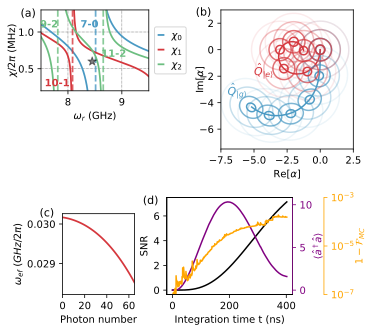

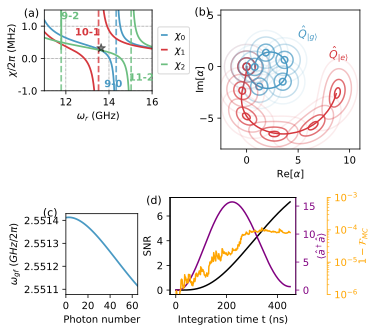

In [87]:
def get_axis():
    fig = plt.figure(figsize=(5, 4.5))
    gs_chi = fig.add_gridspec(nrows=1, ncols=1,left=0.1, right=0.4,bottom=0.73,top = 0.98)
    ax_chi = fig.add_subplot(gs_chi[0])
    gs_alpha = fig.add_gridspec(nrows=1, ncols=1,left=0.59, right=0.98, bottom=0.55,top = 0.98)
    ax_alpha = fig.add_subplot(gs_alpha[0])
    gs_snr = fig.add_gridspec(nrows=1, ncols=1,left=0.45, right=0.8, bottom=0.10,top = 0.4)
    ax_snr = fig.add_subplot(gs_snr[0])

    gs_Lambda = fig.add_gridspec(nrows=1, ncols=1,left=0.16, right=0.36, bottom=0.10,top = 0.35)
    ax_Lambda = fig.add_subplot(gs_Lambda[0])

    ax_chi.text(-0.19, 1.02, '(a)', transform=ax_chi.transAxes, fontsize=11, va='top', color='black')
    ax_alpha.text(-0.19, 1.02, '(b)', transform=ax_alpha.transAxes, fontsize=11, va='top', color='black')
    ax_Lambda.text(-0.32, 1.07, '(c)', transform=ax_Lambda.transAxes, fontsize=11, va='top', color='black')
    ax_snr.text(-0.19, 1.02, '(d)', transform=ax_snr.transAxes, fontsize=11, va='top', color='black')

    return fig, ax_chi, ax_alpha, ax_snr, ax_Lambda

# e-f qubit
fig, ax_chi, ax_alpha, ax_snr, ax_Lambda = get_axis()
plot_sweep_er_ef(ax_chi)
plot_ef_alpha(ax_alpha)
plot_ef_qfunc(ax_alpha)
plot_ef_readout(ax_snr)
plot_ef_qbt_non_linearity(ax_Lambda,Lamda = None)
ax_alpha.text(-7,-2.5,r'$\hat{Q}_{|g\rangle}$',fontsize=11,va='top',color = '#4999c3')
ax_alpha.text(-5,-1,r'$\hat{Q}_{|e\rangle}$',fontsize=11,va='top',color = '#d5373d')
plt.savefig("ef_readout.pdf", transparent=True)

fig, ax_chi, ax_alpha, ax_snr, ax_Lambda = get_axis()
plot_sweep_er_gf(ax_chi)
plot_gf_alpha(ax_alpha)
plot_gf_qfunc(ax_alpha)
plot_gf_qbt_non_linearity(ax_Lambda,Lamda = None)
ax_alpha.text(5,4,r'$\hat{Q}_{|g\rangle}$',fontsize=11,va='top',color = '#4999c3')
ax_alpha.text(8,2,r'$\hat{Q}_{|e\rangle}$',fontsize=11,va='top',color = '#d5373d')
plot_gf_readout(ax_snr)
plt.savefig("gf_readout.pdf", transparent=True)